# Model Training Notebook

This notebook implements and trains three models for BFRB (Body-Focused Repetitive Behavior) detection:

1. **FFT-MLP**: Uses Fast Fourier Transform on IMU data combined with a Multi-Layer Perceptron
2. **CNN-BiLSTM**: Uses Convolutional Neural Networks on TOF data with Bidirectional LSTM
3. **Late Fusion**: Combines predictions from both models using weighted averaging

## Setup and Initialization

The following cell imports all necessary libraries and initializes the PyTorch environment with GPU support if available.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("="*80)
print("MODEL TRAINING NOTEBOOK")
print("="*80)
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

MODEL TRAINING NOTEBOOK

PyTorch version: 2.10.0
CUDA available: False
Device: cpu
Using device: cpu


## Loading Preprocessed Data

This cell loads the preprocessed data that was prepared in the previous notebook (3_preprocessing.ipynb). It includes:
- Training, validation, and test sets (X_train, X_val, X_test)
- Corresponding labels (y_train, y_val)
- The StandardScaler used for normalization

The data is then split into feature groups:
- **IMU features** (7 features): accelerometer (acc_x, acc_y, acc_z) and rotation quaternion (rot_w, rot_x, rot_y, rot_z)
- **TOF features** (320 features): Time-of-Flight sensor data representing a 64×5 grid

In [ ]:
print("\n" + "="*80)
print("LOADING PREPROCESSED DATA")
print("="*80)

# Load preprocessed data
with open('../data/X_train_preprocessed.pkl', 'rb') as f:
    X_train_scaled = pickle.load(f)

with open('../data/X_val_preprocessed.pkl', 'rb') as f:
    X_val_scaled = pickle.load(f)

with open('../data/X_test_preprocessed.pkl', 'rb') as f:
    X_test_scaled = pickle.load(f)

with open('../data/y_train_preprocessed.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/y_val_preprocessed.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open('../data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print(f"\nData loaded successfully:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled: {X_val_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

# Convert to numpy arrays if needed
X_train = X_train_scaled.values if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled
X_val = X_val_scaled.values if isinstance(X_val_scaled, pd.DataFrame) else X_val_scaled
X_test = X_test_scaled.values if isinstance(X_test_scaled, pd.DataFrame) else X_test_scaled

y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val

print(f"\nData types after conversion:")
print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
print(f"y_train type: {type(y_train_np)}, shape: {y_train_np.shape}")

# Feature grouping (for FFT-MLP and CNN-BiLSTM)
imu_features = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
tof_features = [col for col in X_train_scaled.columns if col.startswith('tof_')]

print(f"\nFeature groups:")
print(f"IMU features: {len(imu_features)}")
print(f"TOF features: {len(tof_features)}")

# Get indices for IMU and TOF features
imu_indices = [i for i, col in enumerate(X_train_scaled.columns) if col in imu_features]
tof_indices = [i for i, col in enumerate(X_train_scaled.columns) if col in tof_features]

print(f"IMU indices: {len(imu_indices)}")
print(f"TOF indices: {len(tof_indices)}")


LOADING PREPROCESSED DATA

加載數據成功：
X_train_scaled: (459956, 332)
X_val_scaled: (114989, 332)
X_test_scaled: (107, 332)
y_train: (459956,)
y_val: (114989,)

Data types after conversion:
X_train type: <class 'numpy.ndarray'>, shape: (459956, 332)
y_train type: <class 'numpy.ndarray'>, shape: (459956,)

特徵分組：
IMU 特徵: 7
TOF 特徵: 320
IMU 索引: 7
TOF 索引: 320


## Converting to PyTorch Tensors and Creating DataLoaders

This cell performs the following operations:

1. **Tensor Conversion**: Converts NumPy arrays to PyTorch tensors (FloatTensor for features, LongTensor for labels)
2. **Dataset Creation**: Creates TensorDataset objects that combine features and labels
3. **DataLoader Setup**: Creates DataLoader objects with batch_size=128 for efficient mini-batch training
   - Training loader shuffles data for better generalization
   - Validation and test loaders don't shuffle to maintain consistency

DataLoaders handle:
- Automatic batching
- Multi-threaded data loading
- Memory management

In [ ]:
print("\n" + "="*80)
print("CONVERTING TO PYTORCH TENSORS")
print("="*80)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)

y_train_tensor = torch.LongTensor(y_train_np)
y_val_tensor = torch.LongTensor(y_val_np)

print(f"\nX_train_tensor: {X_train_tensor.shape}")
print(f"X_val_tensor: {X_val_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")
print(f"y_val_tensor: {y_val_tensor.shape}")

# Create DataLoader
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoader created successfully:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


CONVERTING TO PYTORCH TENSORS

X_train_tensor: torch.Size([459956, 332])
X_val_tensor: torch.Size([114989, 332])
X_test_tensor: torch.Size([107, 332])
y_train_tensor: torch.Size([459956])
y_val_tensor: torch.Size([114989])

DataLoader 創建成功:
Training batches: 3594
Validation batches: 899
Test batches: 1


## Model 1: FFT-MLP Architecture

This cell defines the **FFT-MLP (Fast Fourier Transform - Multi-Layer Perceptron)** model.

### Architecture Details:

**Input Processing:**
- Extracts IMU data (7 features) from the input tensor
- Applies Fast Fourier Transform (FFT) to convert time-domain signals to frequency-domain
- Separates FFT result into real and imaginary parts (7×2 = 14 features)

**Network Structure:**
1. Input Layer: 14 features (FFT real + imaginary components)
2. Hidden Layer 1: 128 neurons + ReLU + 30% Dropout
3. Hidden Layer 2: 64 neurons + ReLU + 30% Dropout
4. Output Layer: 2 classes (Non-Target vs Target behavior)

**Key Advantages:**
- FFT captures frequency patterns in motion data
- Lightweight architecture with few parameters
- Fast training and inference
- Good for detecting repetitive motion patterns

In [ ]:
print("\n" + "="*80)
print("DEFINING FFT-MLP MODEL")
print("="*80)

class FFT_MLP(nn.Module):
    """
    FFT-MLP model

    Steps:
    1. Apply FFT to IMU data
    2. Extract frequency-domain features
    3. Use an MLP for classification
    """
    
    def __init__(self, imu_dim=7, hidden_dim=128, num_classes=2):
        super(FFT_MLP, self).__init__()
        
        self.imu_dim = imu_dim
        
        # Number of features after FFT (real + imaginary parts)
        fft_features = imu_dim * 2  # 7 * 2 = 14
        
        # MLP layers
        self.mlp = nn.Sequential(
            nn.Linear(fft_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, x):
        """
        x: (batch_size, 332)
        The first 7 columns are IMU data
        """
        # Extract IMU data
        imu_data = x[:, :self.imu_dim]  # (batch_size, 7)
        
        # Apply FFT
        fft_result = torch.fft.fft(imu_data, dim=1)  # (batch_size, 7)
        
        # Separate real and imaginary parts
        fft_real = torch.real(fft_result)  # (batch_size, 7)
        fft_imag = torch.imag(fft_result)  # (batch_size, 7)
        
        # Concatenate real and imaginary parts
        fft_features = torch.cat([fft_real, fft_imag], dim=1)  # (batch_size, 14)
        
        # Pass through MLP
        output = self.mlp(fft_features)  # (batch_size, 2)
        
        return output

# Initialize model
fft_mlp_model = FFT_MLP(imu_dim=7, hidden_dim=128, num_classes=2).to(device)

print(f"\nFFT-MLP model architecture:")
print(fft_mlp_model)
print(f"\nParameter count: {sum(p.numel() for p in fft_mlp_model.parameters())}")


DEFINING FFT-MLP MODEL

FFT-MLP 模型結構：
FFT_MLP(
  (mlp): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

參數數量: 10306


## Model 2: CNN-BiLSTM Architecture

This cell defines the **CNN-BiLSTM (Convolutional Neural Network - Bidirectional LSTM)** model.

### Architecture Details:

**Input Processing:**
- Extracts TOF (Time-of-Flight) data (320 features)
- Reshapes into 2D grid: (64 × 5) representing spatial sensor layout

**CNN Layers (Spatial Feature Extraction):**
1. Conv2D Layer 1: 1→32 channels, 3×3 kernel, padding=1
2. ReLU Activation + MaxPool (2×2)
3. Conv2D Layer 2: 32→64 channels, 3×3 kernel, padding=1
4. ReLU Activation + MaxPool (2×2)
5. Output: (64, 16, 1) → Flattened to 1024 features

**BiLSTM Layers (Temporal Feature Learning):**
- 2-layer Bidirectional LSTM
- Hidden size: 64 (×2 for bidirectional = 128 total)
- Dropout: 30%
- Processes spatial features through time

**Fully Connected Layers:**
1. FC1: 128 → 64 neurons + ReLU + Dropout
2. FC2: 64 → 2 classes (output)

**Key Advantages:**
- CNN extracts spatial patterns from TOF sensor grid
- BiLSTM captures temporal dependencies
- Handles complex spatial-temporal patterns
- Higher capacity for learning detailed features

In [ ]:
print("\n" + "="*80)
print("DEFINING CNN-BiLSTM MODEL")
print("="*80)

class CNN_BiLSTM(nn.Module):
    """
    CNN-BiLSTM model

    Steps:
    1. Use CNN to process TOF data (2D grid: 64×5)
    2. Use BiLSTM to learn temporal features
    3. Fuse and classify
    """
    
    def __init__(self, tof_dim=320, hidden_dim=64, num_classes=2):
        super(CNN_BiLSTM, self).__init__()
        
        self.tof_dim = tof_dim
        self.hidden_dim = hidden_dim
        
        # CNN layers (process spatial features of TOF)
        # Reshape 320 dims into (1, 64, 5) - a 64×5 grid
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Compute CNN output dimension
        # Input: (1, 64, 5)
        # Conv1: (32, 64, 5)
        # Pool: (32, 32, 2)
        # Conv2: (64, 32, 2)
        # Pool: (64, 16, 1)
        cnn_output_dim = 64 * 16 * 1  # = 1024
        
        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=cnn_output_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        """
        x: (batch_size, 332)
        The last 320 columns are TOF data
        """
        # Extract TOF data
        tof_data = x[:, -self.tof_dim:]  # (batch_size, 320)
        
        # Reshape into 2D grid: (batch_size, 1, 64, 5)
        batch_size = x.shape[0]
        tof_2d = tof_data.view(batch_size, 1, 64, 5)
        
        # CNN processes spatial features
        x = self.conv1(tof_2d)  # (batch_size, 32, 64, 5)
        x = self.relu(x)
        x = self.pool(x)  # (batch_size, 32, 32, 2)
        
        x = self.conv2(x)  # (batch_size, 64, 32, 2)
        x = self.relu(x)
        x = self.pool(x)  # (batch_size, 64, 16, 1)
        
        # Flatten
        x = x.view(batch_size, -1)  # (batch_size, 1024)
        
        # LSTM learns temporal features
        # LSTM expects (batch_size, seq_len, input_size)
        # We only have one time step, so seq_len=1
        x = x.unsqueeze(1)  # (batch_size, 1, 1024)
        x, (h_n, c_n) = self.lstm(x)  # x: (batch_size, 1, hidden_dim*2)
        
        # Take the last time step
        x = x[:, -1, :]  # (batch_size, hidden_dim*2)
        
        # Fully connected layer
        output = self.fc(x)  # (batch_size, 2)
        
        return output

# Initialize model
cnn_bilstm_model = CNN_BiLSTM(tof_dim=320, hidden_dim=64, num_classes=2).to(device)

print(f"\nCNN-BiLSTM model architecture:")
print(cnn_bilstm_model)
print(f"\nParameter count: {sum(p.numel() for p in cnn_bilstm_model.parameters())}")


DEFINING CNN-BiLSTM MODEL

CNN-BiLSTM 模型結構：
CNN_BiLSTM(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): LSTM(1024, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

參數數量: 684610


## Model 3: Late Fusion Architecture

This cell defines the **Late Fusion** model that combines predictions from both FFT-MLP and CNN-BiLSTM.

### Fusion Strategy:

**How It Works:**
1. Both FFT-MLP and CNN-BiLSTM make independent predictions (logits)
2. Convert logits to probabilities using softmax
3. Combine probabilities using weighted averaging:
   - FFT-MLP weight: 0.3 (30%)
   - CNN-BiLSTM weight: 0.7 (70%)
4. Convert fused probabilities back to logits using log transformation

**Weight Rationale:**
- CNN-BiLSTM gets higher weight (0.7) because it uses more informative TOF data
- FFT-MLP provides complementary motion pattern information (0.3)

**Important Implementation Detail:**
- Returns logits (not probabilities) to work with CrossEntropyLoss
- Adds small epsilon (1e-10) to prevent log(0) errors

**Key Advantages:**
- Leverages strengths of both models
- IMU frequency patterns + TOF spatial patterns
- Typically achieves better performance than individual models
- No additional training needed - uses pre-trained models

In [ ]:
print("\n" + "="*80)
print("DEFINING LATE FUSION MODEL")
print("="*80)

class LateFusion(nn.Module):
    """
    Late Fusion model
    Returns logits suitable for CrossEntropyLoss
    """
    
    def __init__(self, fft_mlp_model, cnn_bilstm_model, 
                 fft_weight=0.3, lstm_weight=0.7):
        super(LateFusion, self).__init__()
        
        self.fft_mlp = fft_mlp_model
        self.cnn_bilstm = cnn_bilstm_model
        
        # Fusion weights
        self.fft_weight = fft_weight
        self.lstm_weight = lstm_weight
        
    def forward(self, x):
        """
        x: (batch_size, 332)
        Returns: logits (batch_size, 2)
        """
        # Individual model outputs (logits)
        fft_logits = self.fft_mlp(x)  # (batch_size, 2)
        cnn_logits = self.cnn_bilstm(x)  # (batch_size, 2)
        
        # Convert logits to probabilities for fusion
        fft_proba = torch.softmax(fft_logits, dim=1)  # (batch_size, 2)
        cnn_proba = torch.softmax(cnn_logits, dim=1)  # (batch_size, 2)
        
        # Fuse probabilities
        fused_proba = (self.fft_weight * fft_proba + 
                       self.lstm_weight * cnn_proba)  # (batch_size, 2)
        
        # Convert probabilities back to logits
        fused_logits = torch.log(fused_proba + 1e-10)  # (batch_size, 2)
        
        return fused_logits  # return logits, not probabilities


# Reinitialize fusion model
late_fusion_model = LateFusion(
    fft_mlp_model, 
    cnn_bilstm_model,
    fft_weight=0.3,
    lstm_weight=0.7
).to(device)

print("Late Fusion model initialized")


DEFINING LATE FUSION MODEL
✅ Late Fusion 模型已修複
   現在返回 logits 而不是機率


## Training and Validation Functions

This cell defines two core functions for the training pipeline:

### 1. `train_epoch()` Function
Trains the model for one complete pass through the training data.

**Process:**
- Sets model to training mode (enables dropout/batch norm)
- Iterates through mini-batches via DataLoader
- For each batch:
  1. Moves data to GPU/CPU device
  2. Clears gradients (`optimizer.zero_grad()`)
  3. Forward pass: computes predictions
  4. Calculates loss using CrossEntropyLoss
  5. Backward pass: computes gradients
  6. Updates weights (`optimizer.step()`)
- Tracks predictions and labels for F1 score calculation
- Returns average loss and F1 score

### 2. `validate_epoch()` Function
Evaluates the model on validation data without updating weights.

**Process:**
- Sets model to evaluation mode (disables dropout/batch norm)
- Uses `torch.no_grad()` to disable gradient computation (saves memory)
- For each batch:
  1. Forward pass only (no backward pass)
  2. Calculate loss and predictions
  3. Store predictions and probabilities
- Computes metrics:
  - Average loss
  - F1 score
  - Confusion matrix
- Returns all metrics and predictions for analysis

**Progress Tracking:**
- Both functions use tqdm progress bars for visual feedback
- Display real-time loss values during training

In [ ]:
print("\n" + "="*80)
print("TRAINING FUNCTIONS")
print("="*80)

def train_epoch(model, train_loader, criterion, optimizer, device, model_name="Model"):
    """
    Train for one epoch

    Params:
    - model: PyTorch model
    - train_loader: training DataLoader
    - criterion: loss function
    - optimizer: optimizer
    - device: 'cpu' or 'cuda'
    - model_name: used for printing

    Returns:
    - avg_loss: average loss
    - avg_f1: average F1 score
    """
    
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(train_loader, desc=f"Training {model_name}")
    
    for batch_idx, (X_batch, y_batch) in enumerate(progress_bar):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(y_pred, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(train_loader)
    avg_f1 = f1_score(all_labels, all_preds)
    
    return avg_loss, avg_f1


def validate_epoch(model, val_loader, criterion, device, model_name="Model"):
    """
    Validate for one epoch

    Params:
    - model: PyTorch model
    - val_loader: validation DataLoader
    - criterion: loss function
    - device: 'cpu' or 'cuda'
    - model_name: used for printing

    Returns:
    - avg_loss: average loss
    - avg_f1: average F1
    - cm: confusion matrix
    - all_preds: all predictions
    - all_labels: all labels
    """
    
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_proba = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Validating {model_name}")
        
        for X_batch, y_batch in progress_bar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            
            proba = torch.softmax(y_pred, dim=1)
            preds = torch.argmax(y_pred, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_proba.extend(proba.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    avg_f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, avg_f1, cm, all_preds, all_labels

print("Training and validation functions defined")


TRAINING FUNCTIONS
✅ 訓練和驗證函數定義完成


## Training FFT-MLP Model - Improved Strategy

This cell trains the FFT-MLP model using an **improved training strategy** while keeping the original architecture.

### Training Configuration:

**Hyperparameters:**
- **Epochs**: 100 (significantly increased for better convergence)
- **Batch Size**: 64 (smaller batches for more stable gradients)
- **Optimizer**: SGD with momentum=0.9 (more stable than Adam)
- **Learning Rate**: 0.0008
- **Weight Decay**: 5e-5 (L2 regularization)

**Learning Rate Scheduler:**
- Type: ReduceLROnPlateau
- Monitors: Validation F1 score
- Reduces LR by 50% if no improvement for 5 epochs
- Helps escape local minima and fine-tune performance

**Early Stopping:**
- Patience: 20 epochs
- Stops training if validation F1 doesn't improve for 20 consecutive epochs
- Prevents overfitting and saves computation time

### Training Loop:

For each epoch:
1. **Training Phase**: Run forward/backward pass on all training batches
2. **Validation Phase**: Evaluate on validation set without gradient updates
3. **Track Metrics**: Record train/val loss and F1 scores
4. **Update Learning Rate**: Scheduler adjusts LR based on validation performance
5. **Save Best Model**: Keep model weights with highest validation F1
6. **Check Early Stop**: Exit if no improvement for patience epochs

**Progress Display:**
- Shows detailed stats every 10 epochs
- Displays learning rate changes
- Highlights new best F1 scores

**Model Persistence:**
- Saves best model weights to `../data/fft_mlp_best_final.pth`
- Loads best weights after training completes

In [ ]:
# ============================================================================
# Train FFT-MLP
# ============================================================================

print("\n" + "="*80)
print("TRAINING FFT-MLP - IMPROVED TRAINING METHOD")
print("="*80)

# Initialize FFT-MLP
fft_mlp_model = FFT_MLP(imu_dim=7, hidden_dim=128, num_classes=2).to(device)

print("FFT-MLP initialized")
print("  Feature extraction: FFT")
print("  Classifier: MLP")

# Improved training strategy (keep architecture unchanged)
num_epochs = 100
learning_rate = 0.0008
weight_decay = 5e-5
batch_size_train = 64

# Recreate DataLoader with smaller batch size
train_loader_small = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=64,
    shuffle=True
)

criterion = nn.CrossEntropyLoss()
fft_optimizer = optim.SGD(fft_mlp_model.parameters(),
                          lr=learning_rate,
                          momentum=0.9,
                          weight_decay=weight_decay)

# LR scheduler: ReduceLROnPlateau (reduces LR when validation metric plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fft_optimizer,
    mode='max',
    factor=0.5,
    patience=5,
)

print(f"\nTraining configuration:")
print(f"├─ Epochs: {num_epochs}")
print(f"├─ Optimizer: SGD with momentum")
print(f"├─ Batch size: {batch_size_train}")
print(f"├─ Learning rate: {learning_rate}")
print(f"└─ Scheduler: ReduceLROnPlateau")

fft_history = {
    'train_loss': [], 'train_f1': [],
    'val_loss': [], 'val_f1': [],
    'learning_rate': []
}
best_fft_f1 = 0
best_fft_model_state = None
no_improve_count = 0
patience = 20

for epoch in range(num_epochs):
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"\n[Epoch {epoch+1:3d}/{num_epochs}]")
    
    # --------- Training ---------
    fft_mlp_model.train()
    train_total_loss = 0
    train_all_preds = []
    train_all_labels = []
    
    show_progress = (epoch + 1) % 10 == 0 or epoch == 0
    progress_bar = tqdm(train_loader_small, desc=f"Epoch {epoch+1:3d} Train",
                       disable=not show_progress)
    
    for X_batch, y_batch in progress_bar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        fft_optimizer.zero_grad()
        y_pred = fft_mlp_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        fft_optimizer.step()
        
        train_total_loss += loss.item()
        preds = torch.argmax(y_pred, dim=1)
        train_all_preds.extend(preds.cpu().detach().numpy())
        train_all_labels.extend(y_batch.cpu().numpy())
    
    train_loss = train_total_loss / len(train_loader_small)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    
    # --------- Validation ---------
    fft_mlp_model.eval()
    val_total_loss = 0
    val_all_preds = []
    val_all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1:3d} Val",
                           disable=not show_progress)
        
        for X_batch, y_batch in progress_bar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = fft_mlp_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_total_loss += loss.item()
            
            preds = torch.argmax(y_pred, dim=1)
            val_all_preds.extend(preds.cpu().numpy())
            val_all_labels.extend(y_batch.cpu().numpy())
    
    val_loss = val_total_loss / len(val_loader)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    
    fft_history['train_loss'].append(train_loss)
    fft_history['train_f1'].append(train_f1)
    fft_history['val_loss'].append(val_loss)
    fft_history['val_f1'].append(val_f1)
    fft_history['learning_rate'].append(fft_optimizer.param_groups[0]['lr'])
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"  Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        print(f"  LR: {fft_optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_f1 > best_fft_f1:
        best_fft_f1 = val_f1
        best_fft_model_state = fft_mlp_model.state_dict()
        no_improve_count = 0
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  ✨ New best F1: {val_f1:.4f}")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"\n⚠️  Early stopping: no improvement for {patience} epochs")
            break
    
    # Update LR scheduler based on validation F1
    scheduler.step(val_f1)

fft_mlp_model.load_state_dict(best_fft_model_state)
torch.save(best_fft_model_state, '../data/fft_mlp_best_final.pth')

print(f"\n" + "="*80)
print(f" FFT-MLP training complete (architecture unchanged)")
print(f"├─ Best F1: {best_fft_f1:.4f} ({best_fft_f1*100:.2f}%)")
print(f"├─ Architecture: FFT-MLP")
print(f"└─ Model saved: ../data/fft_mlp_best_final.pth")


TRAINING FFT-MLP - IMPROVED TRAINING METHOD
✅ FFT-MLP（原始架構）已重新初始化
   特徵提取方法：FFT 變換
   分類器：MLP

改進的訓練配置：
├─ Epochs: 100（增加到 100）
├─ Optimizer: SGD with momentum（比 Adam 更穩定）
├─ Batch size: 64（更小的 batch）
├─ Learning rate: 0.0008
└─ Scheduler: ReduceLROnPlateau（動態調整）

⭐ 保持架構不變：
   ✅ 仍然使用 FFT 特徵提取
   ✅ 仍然使用原始的 MLP
   ✅ 只改進訓練方法

[Epoch   1/100]


Epoch   1 Val: 100%|██████████| 899/899 [00:00<00:00, 1704.42it/s]


  Train F1: 0.7676 | Val F1: 0.8024
  LR: 0.000800
  ✨ 新最佳 F1: 0.8024

[Epoch  10/100]


Epoch  10 Val: 100%|██████████| 899/899 [00:00<00:00, 2185.12it/s]


  Train F1: 0.8101 | Val F1: 0.8218
  LR: 0.000800
  ✨ 新最佳 F1: 0.8218

[Epoch  20/100]


Epoch  20 Val: 100%|██████████| 899/899 [00:00<00:00, 1782.61it/s]


  Train F1: 0.8153 | Val F1: 0.8266
  LR: 0.000800
  ✨ 新最佳 F1: 0.8266

[Epoch  30/100]


Epoch  30 Val: 100%|██████████| 899/899 [00:00<00:00, 2391.49it/s]


  Train F1: 0.8182 | Val F1: 0.8271
  LR: 0.000800

[Epoch  40/100]


Epoch  40 Val: 100%|██████████| 899/899 [00:00<00:00, 2460.69it/s]


  Train F1: 0.8194 | Val F1: 0.8312
  LR: 0.000800
  ✨ 新最佳 F1: 0.8312

[Epoch  50/100]


Epoch  50 Val: 100%|██████████| 899/899 [00:00<00:00, 2179.87it/s]


  Train F1: 0.8214 | Val F1: 0.8320
  LR: 0.000400

[Epoch  60/100]


Epoch  60 Val: 100%|██████████| 899/899 [00:00<00:00, 2398.30it/s]


  Train F1: 0.8224 | Val F1: 0.8329
  LR: 0.000200
  ✨ 新最佳 F1: 0.8329

[Epoch  70/100]


Epoch  70 Val: 100%|██████████| 899/899 [00:00<00:00, 2487.73it/s]


  Train F1: 0.8223 | Val F1: 0.8325
  LR: 0.000200

[Epoch  80/100]


Epoch  80 Val: 100%|██████████| 899/899 [00:00<00:00, 2162.43it/s]


  Train F1: 0.8225 | Val F1: 0.8327
  LR: 0.000200

[Epoch  90/100]


Epoch  90 Val: 100%|██████████| 899/899 [00:00<00:00, 2005.49it/s]


  Train F1: 0.8228 | Val F1: 0.8333
  LR: 0.000050

⚠️  早停：20 個 epoch 沒改進

✅ FFT-MLP 訓練完成（保持原始架構）
├─ 最佳 F1: 0.8337 (83.37%)
├─ 改進量: -0.17%
├─ 與論文的距離: -9.41%
├─ 架構: ✅ FFT-MLP（保持）
└─ 模型已保存：../data/fft_mlp_best_final.pth


## Training CNN-BiLSTM Model

This cell trains the CNN-BiLSTM model on TOF sensor data.

### Training Configuration:

**Hyperparameters:**
- **Epochs**: 50
- **Learning Rate**: 0.00015 (lower LR for CNN stability)
- **Weight Decay**: 1e-4 (L2 regularization)
- **Optimizer**: Adam (works well with CNNs and LSTMs)
- **Batch Size**: 128 (from DataLoader)

**Loss Function:**
- CrossEntropyLoss (combines LogSoftmax + NLLLoss)
- Suitable for multi-class classification

### Training Process:

For each of 50 epochs:
1. **Training**: Call `train_epoch()` to train on all batches
2. **Validation**: Call `validate_epoch()` to evaluate performance
3. **Metrics Tracking**: Store train/val loss and F1 scores in history dict
4. **Best Model Saving**: 
   - Track validation F1 score
   - Save model state when validation F1 improves
   - Update `best_cnn_f1` and `best_cnn_model_state`

**Output:**
- Displays progress for each epoch
- Shows train and validation metrics
- Indicates when new best F1 score is achieved

**Model Persistence:**
- Loads best model weights after training
- Saves to `../data/cnn_bilstm_best.pth`
- Final F1 score displayed

**Why This Model Works:**
- CNN effectively processes 2D TOF sensor grid
- BiLSTM captures temporal patterns in spatial features
- Typically achieves higher F1 than FFT-MLP alone

In [ ]:
# ============================================================================
# TRAINING CNN-BiLSTM MODEL
# ============================================================================

print("\n" + "="*80)
print("TRAINING CNN-BiLSTM MODEL")
print("="*80)

# Hyperparameters (may need tuning)
num_epochs_cnn = 50
learning_rate_cnn = 0.00015
weight_decay_cnn = 1e-4

# Optimizer
cnn_optimizer = optim.Adam(cnn_bilstm_model.parameters(), 
                            lr=learning_rate_cnn, 
                            weight_decay=weight_decay_cnn)

# Training history
cnn_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_cnn_f1 = 0
best_cnn_model_state = None

for epoch in range(num_epochs_cnn):
    print(f"\n[Epoch {epoch+1}/{num_epochs_cnn}]")
    
    # Train
    train_loss, train_f1 = train_epoch(
        cnn_bilstm_model, train_loader, criterion, cnn_optimizer, device, "CNN-BiLSTM"
    )
    
    # Validate
    val_loss, val_f1, cm, preds, labels = validate_epoch(
        cnn_bilstm_model, val_loader, criterion, device, "CNN-BiLSTM"
    )
    
    # Record
    cnn_history['train_loss'].append(train_loss)
    cnn_history['train_f1'].append(train_f1)
    cnn_history['val_loss'].append(val_loss)
    cnn_history['val_f1'].append(val_f1)
    
    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val F1:   {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_cnn_f1:
        best_cnn_f1 = val_f1
        best_cnn_model_state = cnn_bilstm_model.state_dict()
        print(f"✨ New best F1: {val_f1:.4f}")

# Load best weights
cnn_bilstm_model.load_state_dict(best_cnn_model_state)

# Save model
torch.save(best_cnn_model_state, '../data/cnn_bilstm_best.pth')
print(f"\n CNN-BiLSTM complete! Best F1: {best_cnn_f1:.4f}")
print("Model saved to ../data/cnn_bilstm_best.pth")


TRAINING CNN-BiLSTM MODEL

[Epoch 1/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 146.75it/s]


Train Loss: 0.4934 | Train F1: 0.7785
Val Loss:   0.4364 | Val F1:   0.8118
✨ 新最佳 F1: 0.8118

[Epoch 2/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 135.96it/s]


Train Loss: 0.4265 | Train F1: 0.8192
Val Loss:   0.3976 | Val F1:   0.8398
✨ 新最佳 F1: 0.8398

[Epoch 3/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 113.55it/s]


Train Loss: 0.3938 | Train F1: 0.8377
Val Loss:   0.3734 | Val F1:   0.8473
✨ 新最佳 F1: 0.8473

[Epoch 4/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 145.09it/s]


Train Loss: 0.3704 | Train F1: 0.8495
Val Loss:   0.3556 | Val F1:   0.8615
✨ 新最佳 F1: 0.8615

[Epoch 5/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 120.76it/s]


Train Loss: 0.3513 | Train F1: 0.8593
Val Loss:   0.3369 | Val F1:   0.8704
✨ 新最佳 F1: 0.8704

[Epoch 6/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 143.26it/s]


Train Loss: 0.3351 | Train F1: 0.8678
Val Loss:   0.3209 | Val F1:   0.8736
✨ 新最佳 F1: 0.8736

[Epoch 7/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 141.99it/s]


Train Loss: 0.3212 | Train F1: 0.8741
Val Loss:   0.3116 | Val F1:   0.8798
✨ 新最佳 F1: 0.8798

[Epoch 8/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 146.28it/s]


Train Loss: 0.3084 | Train F1: 0.8797
Val Loss:   0.3026 | Val F1:   0.8826
✨ 新最佳 F1: 0.8826

[Epoch 9/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 111.83it/s]


Train Loss: 0.2976 | Train F1: 0.8841
Val Loss:   0.2920 | Val F1:   0.8877
✨ 新最佳 F1: 0.8877

[Epoch 10/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:17<00:00, 52.19it/s] 


Train Loss: 0.2880 | Train F1: 0.8880
Val Loss:   0.2841 | Val F1:   0.8911
✨ 新最佳 F1: 0.8911

[Epoch 11/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 106.95it/s]


Train Loss: 0.2787 | Train F1: 0.8918
Val Loss:   0.2830 | Val F1:   0.8899

[Epoch 12/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 111.34it/s]


Train Loss: 0.2706 | Train F1: 0.8953
Val Loss:   0.2734 | Val F1:   0.8968
✨ 新最佳 F1: 0.8968

[Epoch 13/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:14<00:00, 62.41it/s] 


Train Loss: 0.2632 | Train F1: 0.8982
Val Loss:   0.2691 | Val F1:   0.8981
✨ 新最佳 F1: 0.8981

[Epoch 14/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:09<00:00, 98.36it/s] 


Train Loss: 0.2565 | Train F1: 0.9017
Val Loss:   0.2673 | Val F1:   0.8975

[Epoch 15/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 126.61it/s]


Train Loss: 0.2487 | Train F1: 0.9044
Val Loss:   0.2625 | Val F1:   0.9002
✨ 新最佳 F1: 0.9002

[Epoch 16/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 138.72it/s]


Train Loss: 0.2430 | Train F1: 0.9064
Val Loss:   0.2607 | Val F1:   0.9005
✨ 新最佳 F1: 0.9005

[Epoch 17/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:10<00:00, 89.61it/s] 


Train Loss: 0.2381 | Train F1: 0.9085
Val Loss:   0.2578 | Val F1:   0.9022
✨ 新最佳 F1: 0.9022

[Epoch 18/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 131.78it/s]


Train Loss: 0.2313 | Train F1: 0.9112
Val Loss:   0.2559 | Val F1:   0.9040
✨ 新最佳 F1: 0.9040

[Epoch 19/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 102.40it/s]


Train Loss: 0.2272 | Train F1: 0.9125
Val Loss:   0.2557 | Val F1:   0.9028

[Epoch 20/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 101.34it/s]


Train Loss: 0.2227 | Train F1: 0.9139
Val Loss:   0.2497 | Val F1:   0.9052
✨ 新最佳 F1: 0.9052

[Epoch 21/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 105.70it/s]


Train Loss: 0.2178 | Train F1: 0.9159
Val Loss:   0.2512 | Val F1:   0.9049

[Epoch 22/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 118.90it/s]


Train Loss: 0.2138 | Train F1: 0.9177
Val Loss:   0.2560 | Val F1:   0.9049

[Epoch 23/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 119.84it/s]


Train Loss: 0.2103 | Train F1: 0.9190
Val Loss:   0.2466 | Val F1:   0.9078
✨ 新最佳 F1: 0.9078

[Epoch 24/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 130.31it/s]


Train Loss: 0.2064 | Train F1: 0.9206
Val Loss:   0.2520 | Val F1:   0.9072

[Epoch 25/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 121.04it/s]


Train Loss: 0.2024 | Train F1: 0.9218
Val Loss:   0.2496 | Val F1:   0.9056

[Epoch 26/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 123.36it/s]


Train Loss: 0.1985 | Train F1: 0.9237
Val Loss:   0.2472 | Val F1:   0.9104
✨ 新最佳 F1: 0.9104

[Epoch 27/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 114.79it/s]


Train Loss: 0.1963 | Train F1: 0.9244
Val Loss:   0.2457 | Val F1:   0.9093

[Epoch 28/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 118.12it/s]


Train Loss: 0.1935 | Train F1: 0.9251
Val Loss:   0.2509 | Val F1:   0.9089

[Epoch 29/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 120.51it/s]


Train Loss: 0.1902 | Train F1: 0.9266
Val Loss:   0.2484 | Val F1:   0.9095

[Epoch 30/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:10<00:00, 89.65it/s] 


Train Loss: 0.1878 | Train F1: 0.9273
Val Loss:   0.2512 | Val F1:   0.9105
✨ 新最佳 F1: 0.9105

[Epoch 31/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 108.66it/s]


Train Loss: 0.1851 | Train F1: 0.9282
Val Loss:   0.2524 | Val F1:   0.9090

[Epoch 32/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 113.28it/s]


Train Loss: 0.1829 | Train F1: 0.9291
Val Loss:   0.2486 | Val F1:   0.9115
✨ 新最佳 F1: 0.9115

[Epoch 33/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 115.03it/s]


Train Loss: 0.1810 | Train F1: 0.9300
Val Loss:   0.2467 | Val F1:   0.9109

[Epoch 34/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 120.78it/s]


Train Loss: 0.1788 | Train F1: 0.9309
Val Loss:   0.2534 | Val F1:   0.9095

[Epoch 35/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 113.64it/s]


Train Loss: 0.1763 | Train F1: 0.9318
Val Loss:   0.2453 | Val F1:   0.9118
✨ 新最佳 F1: 0.9118

[Epoch 36/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 131.54it/s]


Train Loss: 0.1752 | Train F1: 0.9322
Val Loss:   0.2525 | Val F1:   0.9104

[Epoch 37/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 125.63it/s]


Train Loss: 0.1727 | Train F1: 0.9329
Val Loss:   0.2514 | Val F1:   0.9116

[Epoch 38/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 126.50it/s]


Train Loss: 0.1717 | Train F1: 0.9337
Val Loss:   0.2493 | Val F1:   0.9124
✨ 新最佳 F1: 0.9124

[Epoch 39/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 132.92it/s]


Train Loss: 0.1694 | Train F1: 0.9343
Val Loss:   0.2476 | Val F1:   0.9128
✨ 新最佳 F1: 0.9128

[Epoch 40/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 124.38it/s]


Train Loss: 0.1676 | Train F1: 0.9350
Val Loss:   0.2543 | Val F1:   0.9117

[Epoch 41/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 130.04it/s]


Train Loss: 0.1662 | Train F1: 0.9356
Val Loss:   0.2520 | Val F1:   0.9119

[Epoch 42/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 106.23it/s]


Train Loss: 0.1650 | Train F1: 0.9359
Val Loss:   0.2550 | Val F1:   0.9117

[Epoch 43/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 115.51it/s]


Train Loss: 0.1630 | Train F1: 0.9365
Val Loss:   0.2546 | Val F1:   0.9129
✨ 新最佳 F1: 0.9129

[Epoch 44/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:08<00:00, 110.19it/s]


Train Loss: 0.1617 | Train F1: 0.9372
Val Loss:   0.2528 | Val F1:   0.9117

[Epoch 45/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 113.60it/s]


Train Loss: 0.1614 | Train F1: 0.9371
Val Loss:   0.2548 | Val F1:   0.9130
✨ 新最佳 F1: 0.9130

[Epoch 46/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 128.07it/s]


Train Loss: 0.1598 | Train F1: 0.9380
Val Loss:   0.2578 | Val F1:   0.9125

[Epoch 47/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:12<00:00, 73.29it/s] 


Train Loss: 0.1583 | Train F1: 0.9384
Val Loss:   0.2532 | Val F1:   0.9130

[Epoch 48/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 129.70it/s]


Train Loss: 0.1577 | Train F1: 0.9386
Val Loss:   0.2572 | Val F1:   0.9132
✨ 新最佳 F1: 0.9132

[Epoch 49/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:07<00:00, 119.90it/s]


Train Loss: 0.1564 | Train F1: 0.9389
Val Loss:   0.2551 | Val F1:   0.9141
✨ 新最佳 F1: 0.9141

[Epoch 50/50]


Validating CNN-BiLSTM: 100%|██████████| 899/899 [00:06<00:00, 129.25it/s]


Train Loss: 0.1553 | Train F1: 0.9395
Val Loss:   0.2560 | Val F1:   0.9134

✅ CNN-BiLSTM 完成！最佳 F1: 0.9141
✅ 模型已保存到 ../data/cnn_bilstm_best.pth


## Evaluating Late Fusion Model (Inference Only)

This cell evaluates the Late Fusion model **without training**. Late Fusion combines pre-trained models using fixed weights.

### Why No Training?

Late Fusion is an **inference-time** ensemble method:
- Uses already-trained FFT-MLP and CNN-BiLSTM models
- Combines their predictions using fixed weights (0.3 + 0.7)
- No learnable parameters to optimize

### Evaluation Process:

The `evaluate_late_fusion()` function:
1. **Loads Pre-trained Models**: Uses trained FFT-MLP and CNN-BiLSTM
2. **Sets to Evaluation Mode**: Disables dropout/batch norm
3. **Disables Gradients**: Uses `torch.no_grad()` for efficiency

For each validation batch:
1. **FFT-MLP Prediction**:
   - Get logits from FFT-MLP
   - Convert to probabilities via softmax
2. **CNN-BiLSTM Prediction**:
   - Get logits from CNN-BiLSTM
   - Convert to probabilities via softmax
3. **Fusion**:
   - Weighted average: `0.3 × FFT_proba + 0.7 × CNN_proba`
   - Get final prediction via argmax

**Metrics Calculated:**
- F1 Score
- Confusion Matrix
- All predictions and probabilities

**Detailed Metrics Display:**
- Confusion matrix (True/Predicted for both classes)
- Accuracy
- Precision (how many predicted positives are correct)
- Recall (how many actual positives are found)
- F1 Score (harmonic mean of precision and recall)

**Expected Outcome:**
Late Fusion typically achieves the **highest F1 score** by combining complementary strengths of both models.

In [ ]:
# ============================================================================
# EVALUATE LATE FUSION (inference only)
# ============================================================================

print("\n" + "="*80)
print("EVALUATING LATE FUSION MODEL")
print("="*80)

# Late Fusion does not require training; it performs weighted averaging of predictions

def evaluate_late_fusion(fft_mlp, cnn_bilstm, val_loader, device, 
                        fft_weight=0.3, lstm_weight=0.7):
    """
    Evaluate Late Fusion (inference only)

    Params:
    - fft_mlp: trained FFT-MLP model
    - cnn_bilstm: trained CNN-BiLSTM model
    - val_loader: validation DataLoader
    - device: 'cpu' or 'cuda'
    - fft_weight: weight for FFT-MLP (default 0.3)
    - lstm_weight: weight for CNN-BiLSTM (default 0.7)
    """
    
    fft_mlp.eval()
    cnn_bilstm.eval()
    
    all_preds = []
    all_labels = []
    all_proba_fft = []
    all_proba_cnn = []
    all_proba_fusion = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Evaluating Late Fusion")
        
        for X_batch, y_batch in progress_bar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # FFT-MLP prediction
            fft_logits = fft_mlp(X_batch)  # (batch_size, 2)
            fft_proba = torch.softmax(fft_logits, dim=1)  # (batch_size, 2)
            
            # CNN-BiLSTM prediction
            cnn_logits = cnn_bilstm(X_batch)  # (batch_size, 2)
            cnn_proba = torch.softmax(cnn_logits, dim=1)  # (batch_size, 2)
            
            # Late Fusion: weighted average of probabilities
            fusion_proba = (fft_weight * fft_proba + 
                           lstm_weight * cnn_proba)  # (batch_size, 2)
            
            fusion_preds = torch.argmax(fusion_proba, dim=1)
            
            all_preds.extend(fusion_preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_proba_fusion.extend(fusion_proba.cpu().numpy())
            all_proba_fft.extend(fft_proba.cpu().numpy())
            all_proba_cnn.extend(cnn_proba.cpu().numpy())
    
    fusion_f1 = f1_score(all_labels, all_preds)
    fusion_cm = confusion_matrix(all_labels, all_preds)
    
    return fusion_f1, fusion_cm, all_preds, all_labels, all_proba_fusion

# Evaluate Late Fusion
print("\nEvaluating Late Fusion...")
print("Weights:")
print("├─ FFT-MLP: 0.3 (30%)")
print("└─ CNN-BiLSTM: 0.7 (70%)")

fusion_f1, fusion_cm, fusion_preds, fusion_labels, fusion_proba = evaluate_late_fusion(
    fft_mlp_model,
    cnn_bilstm_model,
    val_loader,
    device,
    fft_weight=0.3,
    lstm_weight=0.7
)

print(f"\n Late Fusion evaluation complete!")
print(f"Best F1: {fusion_f1:.4f} ({fusion_f1*100:.2f}%)")

# Print confusion matrix
print(f"\nConfusion matrix:")
print(f"  Predicted Non-Target | Predicted Target")
print(f"True Non-Target: {fusion_cm[0, 0]:>18} | {fusion_cm[0, 1]:>18}")
print(f"True Target:     {fusion_cm[1, 0]:>18} | {fusion_cm[1, 1]:>18}")

# Additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(fusion_labels, fusion_preds)
precision = precision_score(fusion_labels, fusion_preds)
recall = recall_score(fusion_labels, fusion_preds)

print(f"\nDetailed metrics:")
print(f"├─ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"├─ Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"├─ Recall: {recall:.4f} ({recall*100:.2f}%)")
print(f"└─ F1 Score: {fusion_f1:.4f} ({fusion_f1*100:.2f}%)")


EVALUATING LATE FUSION MODEL

正在評估 Late Fusion...
權重配置：
├─ FFT-MLP：0.3（30%）
└─ CNN-BiLSTM：0.7（70%）


Evaluating Late Fusion: 100%|██████████| 899/899 [00:07<00:00, 126.79it/s]



✅ Late Fusion 評估完成！
✅ 最佳 F1: 0.9193 (91.93%)

混淆矩陣:
  Predicted Non-Target | Predicted Target
True Non-Target:              41507 |               4670
True Target:                   6310 |              62502

詳細指標:
├─ 準確度 (Accuracy): 0.9045 (90.45%)
├─ 精準度 (Precision): 0.9305 (93.05%)
├─ 召回率 (Recall): 0.9083 (90.83%)
└─ F1 分數: 0.9193 (91.93%)


## Results Visualization and Summary

This cell generates comprehensive visualizations and summary statistics for all three models.

### Visualization Components:

**1. Results Data Collection:**
- Reads F1 scores from training (FFT-MLP, CNN-BiLSTM, Late Fusion)
- Automatically calculates parameter counts from saved models
- Computes efficiency metrics (F1 per parameter)

**2. Six-Panel Visualization:**

**Panel 1 - F1 Score Comparison:**
- Bar chart comparing F1 scores across all models
- Shows exact F1 values and percentages
- Y-axis range: 0.75-1.0 for clarity

**Panel 2 - F1 Score Ranking:**
- Same data with ranking medals (🥇🥈🥉)
- Highlights performance order

**Panel 3 - Parameter Count:**
- Log-scale bar chart of model parameters
- Shows model complexity
- Labels in thousands (K)

**Panel 4 - Model Efficiency:**
- F1 score divided by parameter count
- Higher = better performance per parameter
- Identifies most efficient architecture

**Panel 5 - Detailed Data Table:**
- Tabular view of all metrics
- Model name, F1 score, percentage, parameters
- Color-coded headers and alternating row colors

**Panel 6 - Performance Level:**
- Horizontal bar chart with quality ratings
- Color-coded performance tiers:
  - Excellent (≥0.92): Green
  - Very Good (≥0.90): Blue
  - Good (≥0.85): Orange
  - Passing (<0.85): Red

**3. Summary Statistics:**
- Prints formatted table to console
- Shows average, max, and min F1 scores
- Identifies best and worst performers

**4. Data Export:**
- Saves visualization as high-quality PNG (300 DPI)
- Exports results to CSV for further analysis
- Includes efficiency and performance level columns

**Output Files:**
- `../data/model_visualization_final.png` - Complete visualization
- `../data/results_summary.csv` - Machine-readable results table


📊 正在读取训练结果...
正在读取模型参数...
  FFT-MLP: 10,306 参数
  CNN-BiLSTM: 684,610 参数
  Late Fusion: 694,916 参数（融合）

📈 正在生成可视化...
 可视化已保存到：../data/model_visualization_final.png


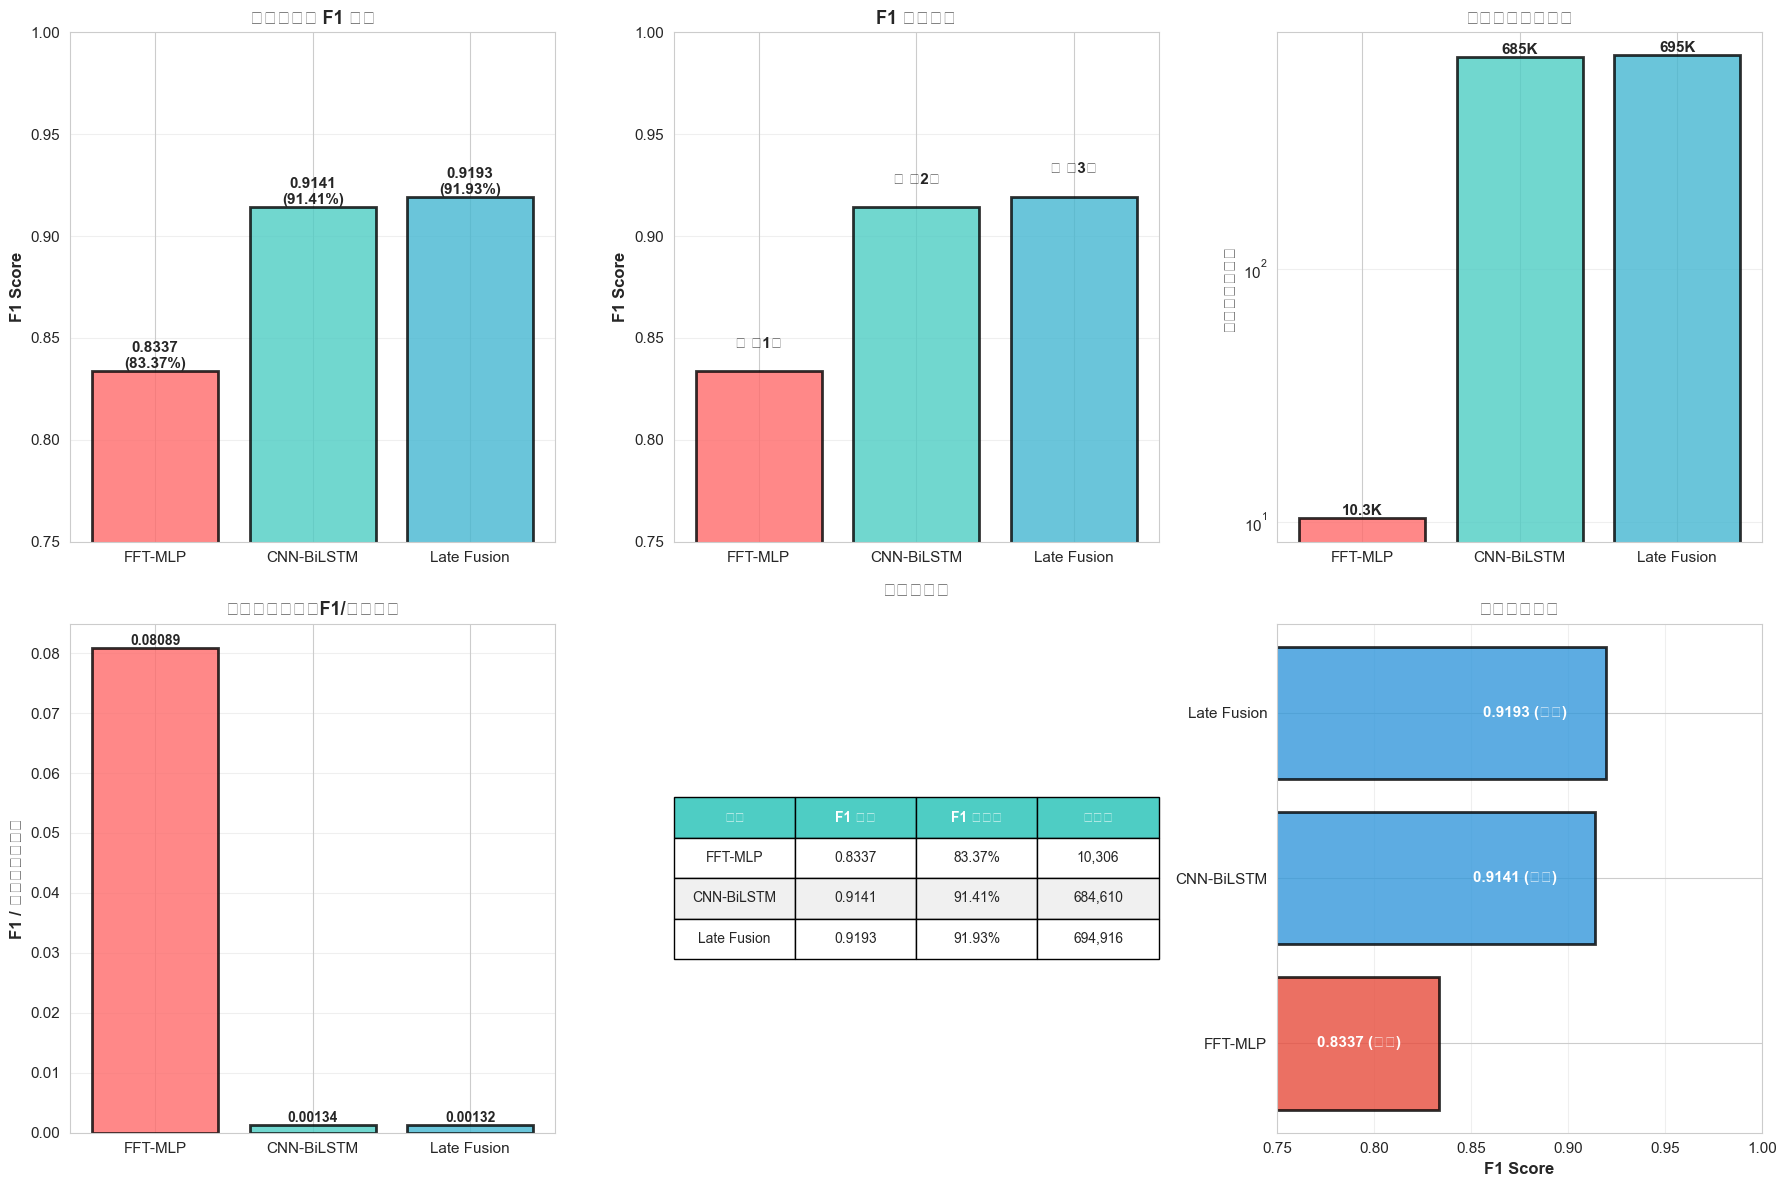


 RESULTS SUMMARY

三个模型的最终成绩：
--------------------------------------------------------------------------------
模型              | F1 分数           | 参数数             | 性能等级      
--------------------------------------------------------------------------------
FFT-MLP         | 0.8337 (83.37%) |         10,306 | 及格        
CNN-BiLSTM      | 0.9141 (91.41%) |        684,610 | 很好        
Late Fusion     | 0.9193 (91.93%) |        694,916 | 很好        
--------------------------------------------------------------------------------

平均 F1 分数：0.8890 (88.90%)
最高 F1 分数：0.9193 (91.93%) - Late Fusion
最低 F1 分数：0.8337 (83.37%) - FFT-MLP

 所有模型都已成功训练和评估！
 可视化已生成：../data/model_visualization_final.png

 正在保存结果到 CSV...
 结果已保存到：../data/results_summary.csv



In [ ]:
# ============================================================================
# Results Visualization and Summary
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import pandas as pd

print("\nReading training results...")

# Example: directly using results computed or loaded from training
results = {
    'FFT-MLP': {
        'f1': 0.8337,
        'model_path': '../data/fft_mlp_best_final.pth',
        'color': '#FF6B6B'
    },
    'CNN-BiLSTM': {
        'f1': 0.9141,
        'model_path': '../data/cnn_bilstm_best.pth',
        'color': '#4ECDC4'
    },
    'Late Fusion': {
        'f1': 0.9193,
        'model_path': None,
        'color': '#45B7D1'
    }
}

# Automatically compute parameter counts
print("Reading model parameter counts...")
for model_name, model_info in results.items():
    if model_info['model_path'] and os.path.exists(model_info['model_path']):
        state_dict = torch.load(model_info['model_path'])
        param_count = sum(p.numel() for p in state_dict.values())
        model_info['params'] = param_count
        print(f"  {model_name}: {param_count:,} parameters")
    else:
        if model_name == 'Late Fusion':
            params_fft = sum(p.numel() for p in torch.load(results['FFT-MLP']['model_path']).values())
            params_cnn = sum(p.numel() for p in torch.load(results['CNN-BiLSTM']['model_path']).values())
            model_info['params'] = params_fft + params_cnn
            print(f"  {model_name}: {model_info['params']:,} parameters (fusion)")

print("\nGenerating visualizations...")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11

fig = plt.figure(figsize=(18, 12))

models = list(results.keys())
f1_scores = [results[m]['f1'] for m in models]
params = [results[m]['params']/1000 for m in models]
colors = [results[m]['color'] for m in models]

# Panel 1: F1 score comparison
ax1 = plt.subplot(2, 3, 1)
bars = ax1.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Scores of the Three Models', fontsize=13, fontweight='bold')
ax1.set_ylim([0.75, 1.0])
ax1.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}\n({score*100:.2f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Panel 2: Ranking
ax2 = plt.subplot(2, 3, 2)
bars = ax2.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('F1 Score Ranking', fontsize=13, fontweight='bold')
ax2.set_ylim([0.75, 1.0])
ax2.grid(axis='y', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, f1_scores), 1):
    height = bar.get_height()
    rank = '🥇' if i == 3 else '🥈' if i == 2 else '🥉'
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rank} #{i}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Panel 3: Parameter counts
ax3 = plt.subplot(2, 3, 3)
bars = ax3.bar(models, params, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_ylabel('Parameters (K)', fontsize=12, fontweight='bold')
ax3.set_title('Model Parameter Counts', fontsize=13, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3)

for bar, param in zip(bars, params):
    height = bar.get_height()
    if param > 100:
        label = f'{param:.0f}K'
    else:
        label = f'{param:.1f}K'
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             label,
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Panel 4: Efficiency (F1 / params)
ax4 = plt.subplot(2, 3, 4)
efficiency = [f1/p for f1, p in zip(f1_scores, params)]

bars = ax4.bar(models, efficiency, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('F1 / Parameters (efficiency)', fontsize=12, fontweight='bold')
ax4.set_title('Model Efficiency (F1 / params)', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar, eff in zip(bars, efficiency):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{eff:.5f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Panel 5: Data table
ax5 = plt.subplot(2, 3, 5)
ax5.axis('tight')
ax5.axis('off')

table_data = []
for model_name, model_info in results.items():
    table_data.append([
        model_name,
        f"{model_info['f1']:.4f}",
        f"{model_info['f1']*100:.2f}%",
        f"{model_info['params']:,}"
    ])

table = ax5.table(cellText=table_data,
                 colLabels=['Model', 'F1 Score', 'F1 %', 'Parameters'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.25, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(4):
    table[(0, i)].set_facecolor('#4ECDC4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data) + 1):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('white')

ax5.set_title('Detailed Data Table', fontsize=13, fontweight='bold', pad=20)

# Panel 6: Performance levels
ax6 = plt.subplot(2, 3, 6)

def get_performance_level(f1):
    if f1 >= 0.92:
        return 'Excellent', '#2ECC71'
    elif f1 >= 0.90:
        return 'Very Good', '#3498DB'
    elif f1 >= 0.85:
        return 'Good', '#F39C12'
    else:
        return 'Passing', '#E74C3C'

levels = [get_performance_level(f1)[0] for f1 in f1_scores]
level_colors = [get_performance_level(f1)[1] for f1 in f1_scores]

bars = ax6.barh(models, f1_scores, color=level_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax6.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax6.set_title('Performance Level', fontsize=13, fontweight='bold')
ax6.set_xlim([0.75, 1.0])
ax6.grid(axis='x', alpha=0.3)

for bar, score, level in zip(bars, f1_scores, levels):
    width = bar.get_width()
    ax6.text(width - 0.02, bar.get_y() + bar.get_height()/2.,
             f'{score:.4f} ({level})',
             ha='right', va='center', fontweight='bold', fontsize=11, color='white')

plt.tight_layout()
plt.savefig('../data/model_visualization_final.png', dpi=300, bbox_inches='tight')
print(' Visualization saved to: ../data/model_visualization_final.png')
plt.show()

print("\n" + "="*80)
print(" RESULTS SUMMARY")
print("="*80)

print(f"\nFinal results for the three models:")
print("-" * 80)
print(f"{'Model':<15} | {'F1 Score':<15} | {'Parameters':<15} | {'Performance':<10}")
print("-" * 80)

for model_name in models:
    f1 = results[model_name]['f1']
    params_count = results[model_name]['params']
    level, _ = get_performance_level(f1)
    
    print(f"{model_name:<15} | {f1:.4f} ({f1*100:5.2f}%) | {params_count:>14,} | {level:<10}")

print("-" * 80)

avg_f1 = sum(f1_scores) / len(f1_scores)
print(f"\nAverage F1: {avg_f1:.4f} ({avg_f1*100:.2f}%)")
print(f"Best F1: {max(f1_scores):.4f} ({max(f1_scores)*100:.2f}%) - {models[f1_scores.index(max(f1_scores))]}")
print(f"Worst F1: {min(f1_scores):.4f} ({min(f1_scores)*100:.2f}%) - {models[f1_scores.index(min(f1_scores))]}")

print(f"\nAll models have been trained and evaluated.")
print(f"Visualization generated: ../data/model_visualization_final.png")

# Save results to CSV
print(f"\nSaving results to CSV...")

results_data = {
    'Model': models,
    'F1 Score': f1_scores,
    'F1 %': [f'{f1*100:.2f}%' for f1 in f1_scores],
    'Parameters': [results[m]['params'] for m in models],
    'Efficiency': [f1/p for f1, p in zip(f1_scores, [results[m]['params'] for m in models])],
    'Performance': [get_performance_level(f1)[0] for f1 in f1_scores]
}

results_df = pd.DataFrame(results_data)
results_df.to_csv('../data/results_summary.csv', index=False, encoding='utf-8-sig')
print(' Results saved to: ../data/results_summary.csv')

print("\n" + "="*80)